# Case - 成型機PHM,  案例分類 - SVM

Copyright © 2019 Hsu Shih-Chieh 

利用SVM建立案例模型並分類辨別

算法筆記: https://hackmd.io/@JHSU/H1YiP5eur


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings, matplotlib, datetime
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datasets import load_moldcase
from utils import set_font_cn
from IPython.display import display
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

set_font_cn()

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Segmentation Models: using `keras` framework.


/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load Data

In [7]:
clist=[]
for i in range(1,6):
    clist.append("case%02d"%i)


In [8]:
data= load_moldcase(clist)
print(data.DESCR)

成型機案例數據
---------------------------

**Data Set Characteristics::**

    :控制器數據: 從控制器取出的螺桿位置, 油壓缸壓力, 料管溫度的數據統計值, 總共有44種數據
    
    :設備健康值數據: 透過高維度SPC監控方法(PCA T2/SPE)計算後的設備健康值, 設備運作時實時運算, 並存入sqlite
    
    :spccol_mapping: PLC數據欄位的中英文對照表
    
    :caseinfo: 每一個案例的詳細資訊



**讀取數據Sample Code**

::
    data= load_moldcase()
    c = data.case01_caseinfo
    df_ctr = data.case01_plc
    df_hv = data.case01_hv


**Model Characteristics**
    
    :設備異常監控: PCA T2/SPE
    
    :設備異常分類(方法一): 案例的參數趨勢分析
        - Source Code: data_molding_TrendAnalysis.ipynb
        - 算法筆記: https://hackmd.io/@JHSU/By3uWuwPH
    
    :設備異常分類(方法二): 分析每一個兩個案例的之間的參數變化相似性
        - Source Code: data_molding_DTW.ipynb
        - 算法筆記: https://hackmd.io/@JHSU/HyCnabcPH
        
    :設備異常分類(方法三): 關聯規則
        - Source Code: data_molding_apriori.ipynb
        - 算法筆記: https://hackmd.io/@JHSU/BJCyWchPr
        
        

專案說明：
這個專案與控制器廠商合作, 從控制器中取出螺桿位置, 油壓缸壓力, 料管溫度這三項特徵數據, 但因為控制器性能限制, 無法將實時數據取出, 退而求其次, 透過控制器本身的SPC監控功能, 取出這三項特

### Pre-process
準備SVC模型訓練要用的數據
    - 控制器數據 - df_ctr


In [9]:

spc_feature=['SPC_7','SPC_6','SPC_40','SPC_9','SPC_19','SPC_20','SPC_24','SPC_28','SPC_32','SPC_33']
spccol_mapping = data.spccol_mapping
dflist = []
for cname in clist:
    c = data[f'{cname}_caseinfo']
    print(c.cname)
    df_ctr = data[f'{cname}_plc'] 
    df_ctr['dt'] = df_ctr['dt'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
    df_hv = data[f'{cname}_hv'] 
    if (df_ctr.shape[0]==0) or (df_hv.shape[0]==0):
        continue
    #df_hv['is_defect'] =  df_hv['isdefect_clamp'] + df_hv['isdefect_eject'] + df_hv['isdefect_inject'] + df_hv['isdefect_temp']
    df_hv['is_defect'] =  df_hv['isdefect_clamp'] 
    df_hv['is_defect'] = df_hv['is_defect'].map(lambda x:x>=1)
    defectmolds = df_hv[df_hv['is_defect']>=1]['moldidx'].values
    df_ctr['isDefect'] = df_ctr['SPC_0'].map(lambda x: 1 if x in defectmolds else 0)
    df_ctr.loc[:c.evt_str]['isDefect']=0
    df_ctr = df_ctr[:c.evt_end]
    dflist.append(df_ctr)

if len(dflist)!=0:
    df_ctr = pd.concat(dflist)
    print(df_ctr['isDefect'].value_counts())
else:
    print('Get Data Error')

D2 A05 9/10 清模
D2 A05 9/11 清模
D2 A05 9/12 清模
D2 A01 9/9 清模
D2 A05 9/9 清模
0    622
1      7
Name: isDefect, dtype: int64


### 模型訓練 
以下為算法步驟
1. StandardScaler
2. PCA
3. SVC
4. KFold Validataion
5. use all training data to train a final model

KFold validataion
==== REPORT ====
acc=0.9893842887473461, recall=0.0


,0,1
0,466,0
1,5,0


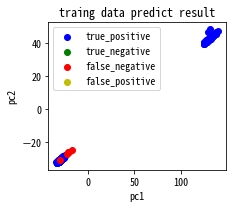

==== REPORT ====
acc=0.9873417721518988, recall=0.0


,0,1
0,156,0
1,2,0


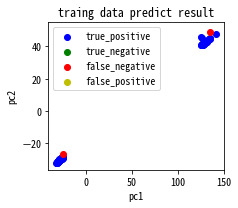

==== REPORT ====
acc=0.9936305732484076, recall=0.4


,0,1
0,466,0
1,3,2


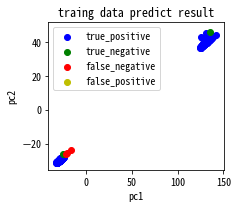

==== REPORT ====
acc=0.9873417721518988, recall=0.0


,0,1
0,156,0
1,2,0


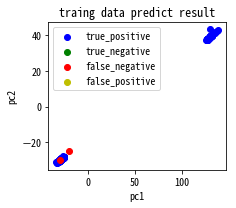

==== REPORT ====
acc=0.9936440677966102, recall=0.4


,0,1
0,467,0
1,3,2


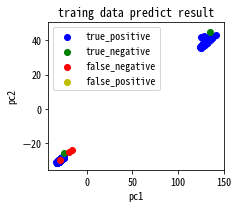

==== REPORT ====
acc=0.9872611464968153, recall=0.0


,0,1
0,155,0
1,2,0


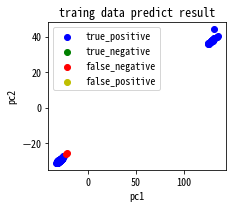

==== REPORT ====
acc=0.9873150105708245, recall=0.3333333333333333


,0,1
0,465,2
1,4,2


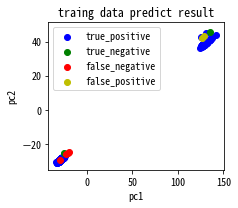

==== REPORT ====
acc=0.9871794871794872, recall=0.0


,0,1
0,154,1
1,1,0


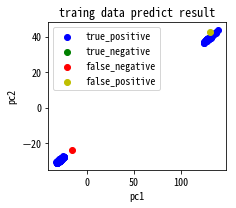

Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=10,
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=1, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [10]:
def myclassification_report(y, pred, pca_X):
    """
    分析Inference結果
        - acccuracy, recall rate
        - confusion matrix
        - pca scatter plot
    Parameters: NA
    Returns: NA
    """                
    print('==== REPORT ====')
    print(f'acc={accuracy_score(y, pred)}, recall={recall_score(y, pred)}')
    display(pd.DataFrame(metrics.confusion_matrix(y, pred)))
    true_positive = [(pred==0)&(y==0)]
    true_negative = [(pred==1)&(y==1)]
    false_positive = [(pred==1)&(y==0)]
    false_negative = [(pred==0)&(y==1)]
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.scatter(pca_X[:,0][true_positive], pca_X[:,1][true_positive],c='b', label='true_positive')
    plt.scatter(pca_X[:,0][true_negative], pca_X[:,1][true_negative],c='g', label='true_negative')
    plt.scatter(pca_X[:,0][false_negative], pca_X[:,1][false_negative],c='r', label='false_negative')
    plt.scatter(pca_X[:,0][false_positive], pca_X[:,1][false_positive],c='y', label='false_positive')
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.legend()
    plt.title('traing data predict result')    
    plt.tight_layout()
    plt.show()


data_X = df_ctr[spc_feature]
data_y = df_ctr['isDefect']
pipe = Pipeline([('sc',StandardScaler()), ('pca',PCA(2)), ('clf', SVC(kernel='poly',random_state=1,gamma=10,C=1))])
kfold=4
skf = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
print('KFold validataion')
for tr_idx, ts_idx in skf.split(data_X, data_y):
    tr_X, tr_y = data_X.iloc[tr_idx], data_y.iloc[tr_idx]
    ts_X, ts_y = data_X.iloc[ts_idx], data_y.iloc[ts_idx]
    pipe.fit(tr_X, tr_y)
    tr_pred = pipe.predict(tr_X)
    ts_pred = pipe.predict(ts_X)
    pca_trX = pipe.named_steps['pca'].transform(tr_X)
    pca_tsX = pipe.named_steps['pca'].transform(ts_X)
    myclassification_report(tr_y, tr_pred, pca_trX)
    myclassification_report(ts_y, ts_pred, pca_tsX)
pipe.fit(data_X, data_y)        



### Inference
SVC Inference, steps:
    1. StandardScaler
    2. PCA
    3. SVC
    4. KFold Validataion
    5. use all training data to train a final model


==== REPORT ====
acc=0.9538461538461539, recall=0.0


,0,1
0,62,0
1,3,0


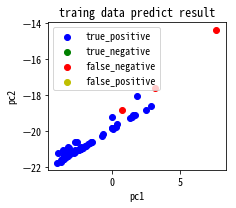

In [11]:
cid='case07'
data_infer= load_moldcase([cid])
c = data_infer[f'{cid}_caseinfo'] 
df_ctr = data_infer[f'{cid}_plc']
df_hv = data_infer[f'{cid}_hv']
df_ctr['dt'] = df_ctr['dt'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

df_hv['is_defect'] =  df_hv['isdefect_clamp'] + df_hv['isdefect_eject'] + df_hv['isdefect_inject'] + df_hv['isdefect_temp']
df_hv['is_defect'] = df_hv['is_defect'].map(lambda x:x>=1)
defectmolds = df_hv[df_hv['is_defect']>=1]['moldidx'].values
df_ctr['isDefect'] = df_ctr['SPC_0'].map(lambda x: 1 if x in defectmolds else 0)
df_ctr.loc[:c.evt_str]['isDefect']=0
df_ctr = df_ctr[:c.evt_end]
data_X = df_ctr[spc_feature]
data_y = df_ctr['isDefect']
pred = pipe.predict(data_X)
pca_X = pipe.named_steps['pca'].transform(data_X)
myclassification_report(data_y, pred, pca_X)
